Model
model.py or model.ipynb
Using saas.csv or log data from api usage of last week
Split data (train/test) and resample by any period except daily, and aggregate using the sum.
Forecast, plot and evaluate using each of the 4 parametric bsed methods we discussed:
simple average
moving average
Holt's linear trend model
Based on previous year/month/etc (your choice)
Using mall customer data
Predict 2018 total monthly sales for store 1 by creating a model using prophet
Predict 2018 total monthly sales for each store by creating a model for each store using prophet.
Return a data frame with the month, storeid, yhat, and the confidence intervals (yhat lower, yhat upper)
Plot the 2018 monthly sales predictions for each store to compare predicted performance. (e.g. line chart where each line represents store id (color), x is the month, y is sales)

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import itertools

# JSON API
import requests
import json

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import Holt
from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_saas = pd.read_csv('saas.csv')

In [3]:
df_saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [4]:
df_saas['sales_date'] = pd.to_datetime(df_saas['Month_Invoiced'])


In [5]:
df_saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 6 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
sales_date           790458 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 36.2+ MB


In [6]:
df_saas.set_index('sales_date', inplace=True)

In [7]:
df_saas.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 5 columns):
Month_Invoiced       790458 non-null object
Customer_Id          790458 non-null int64
Invoice_Id           790458 non-null int64
Subscription_Type    790458 non-null float64
Amount               790458 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 36.2+ MB


In [8]:
df_saas.head(10)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
sales_date,,,,,
2014-01-31,2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,2014-01-31,1000004,5000004,1.0,5.0
2014-01-31,2014-01-31,1000005,5000005,2.0,10.0
2014-01-31,2014-01-31,1000006,5000006,0.0,0.0
2014-01-31,2014-01-31,1000007,5000007,0.0,0.0
2014-01-31,2014-01-31,1000008,5000008,0.0,0.0


In [9]:
aggregation = 'sum'
train = df_saas[:'2016'].Amount.resample('M').agg(aggregation)
test = df_saas['2017':].Amount.resample('M').agg(aggregation)


In [10]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 36
Testing Observations: 12


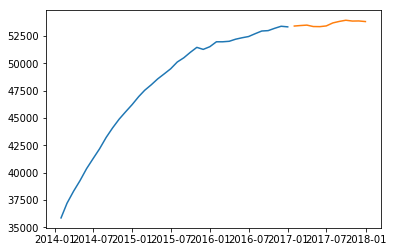

In [11]:
plt.plot(train)
plt.plot(test)
plt.show()

In [12]:
yhat = pd.DataFrame(dict(actual=test))
yhat['avg_forecast'] = train.mean()
yhat.head()

,actual,avg_forecast
sales_date,,
2017-01-31,53395.0,47916.666667
2017-02-28,53440.0,47916.666667
2017-03-31,53480.0,47916.666667
2017-04-30,53350.0,47916.666667
2017-05-31,53340.0,47916.666667


In [13]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


In [14]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

In [15]:
def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    


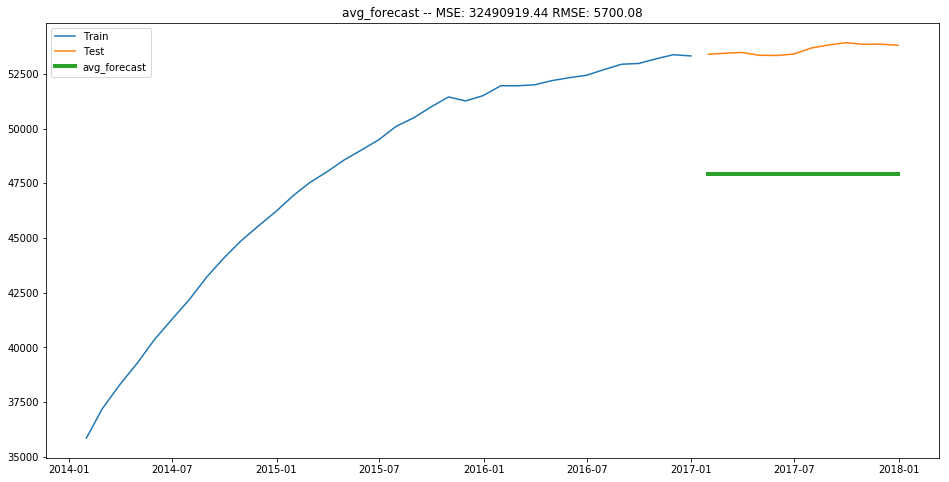

In [16]:
plot_and_eval(yhat.avg_forecast)

In [17]:
periods = 12
yhat['moving_avg_forecast_12'] = train.rolling(12).mean().iloc[-1]

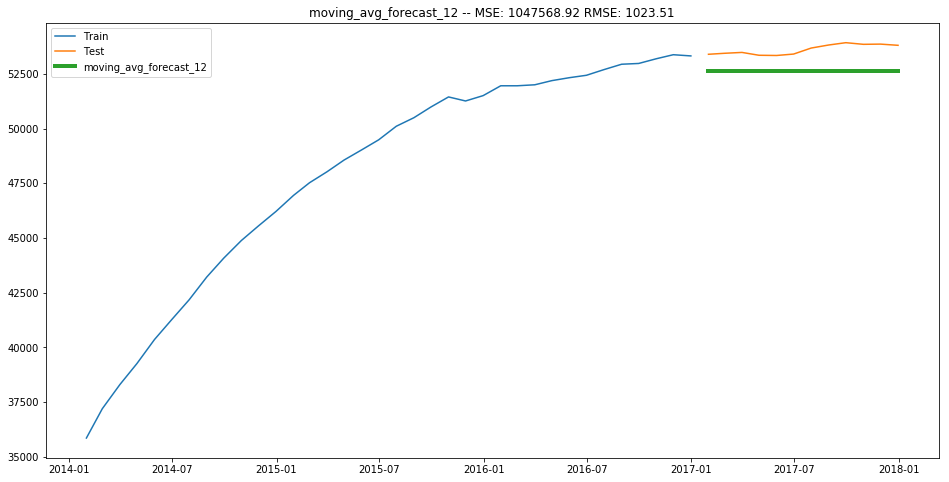

In [18]:
plot_and_eval(yhat.moving_avg_forecast_12)

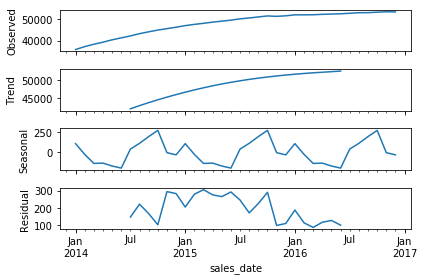

In [19]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [20]:
y_hat = pd.DataFrame(dict(actual=test))
y_hat.head()

,actual
sales_date,
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0


In [21]:
holt = Holt(train).fit(smoothing_level = .6, smoothing_slope = .9)
y_hat['holt_linear'] = holt.forecast(test.shape[0])

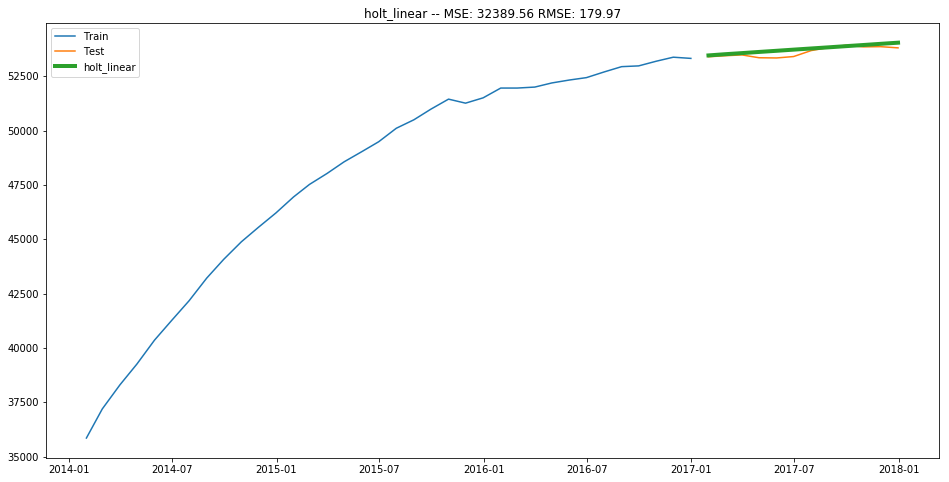

In [22]:
plot_and_eval(y_hat.holt_linear)

In [23]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='sales_date')\
    .set_index(train['2016'].index + 12)

yhat['last_year'] = using_last_year

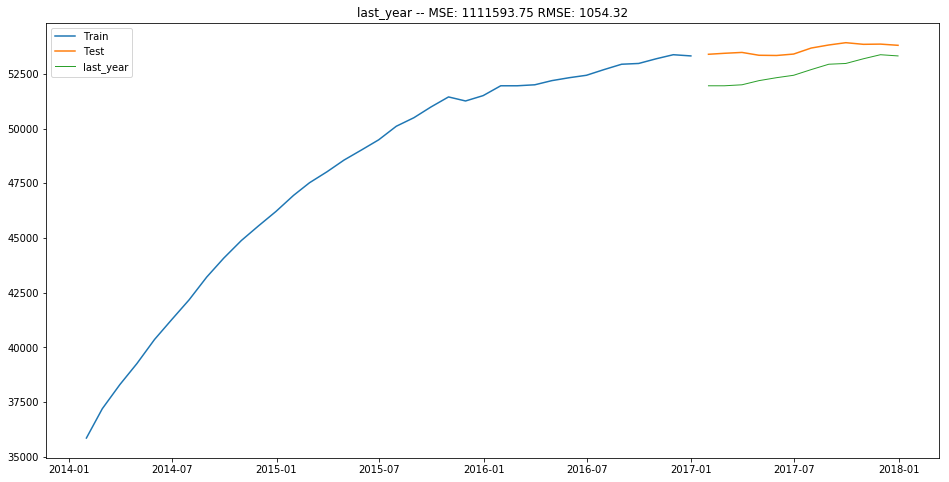

In [24]:
plot_and_eval(yhat.last_year, linewidth=1)

In [25]:
pd.date_range('20170101', periods=12,freq='M')

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', freq='M')

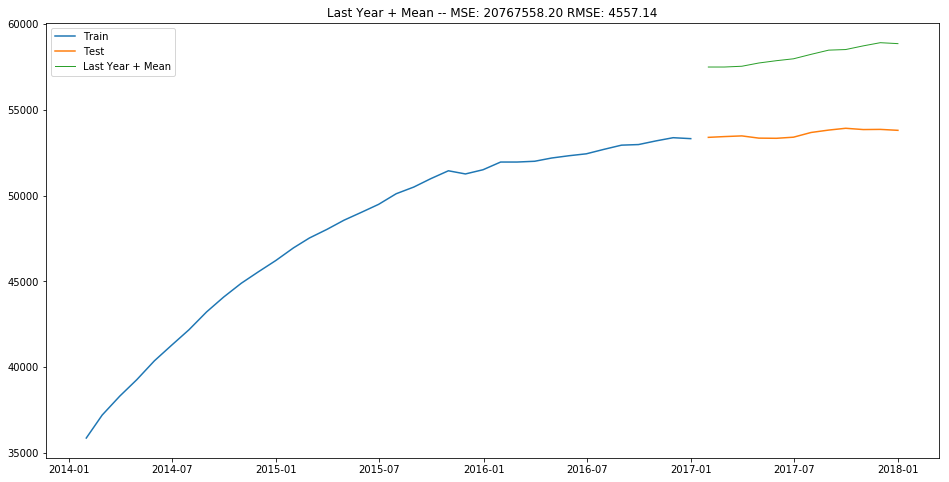

In [26]:
predictions = train['2016'] + train.diff(12).mean()
predictions.index = pd.date_range('20170101', periods=12,freq='M')
# predictions = predictions[:-1]
predictions.name = 'Last Year + Mean'

plot_and_eval(predictions, linewidth=1)

Zach Web data

In [27]:
df = pd.read_csv('Total_dZach.csv')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
item_id        913000 non-null int64
sale_amount    913000 non-null float64
sale_date      913000 non-null object
sale_id        913000 non-null int64
store_id       913000 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 34.8+ MB


Predict 2018 total monthly sales for store 1 by creating a model using prophet
Predict 2018 total monthly sales for each store by creating a model for each store using prophet.
Return a data frame with the month, storeid, yhat, and the confidence intervals (yhat lower, yhat upper)
Plot the 2018 monthly sales predictions for each store to compare predicted performance. (e.g. line chart where each line represents store id (color), x is the month, y is sales)

In [30]:
ddf = df[df['store_id']==3]


In [31]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91300 entries, 3652 to 900217
Data columns (total 5 columns):
item_id        91300 non-null int64
sale_amount    91300 non-null float64
sale_date      91300 non-null object
sale_id        91300 non-null int64
store_id       91300 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.2+ MB


In [32]:
ddf['y'] = ddf.sale_amount 
ddf['ds'] = pd.to_datetime(ddf.sale_date)
ddf.set_index('ds', inplace=True)


In [37]:
ddf.info()

AttributeError: 'Series' object has no attribute 'info'

In [36]:
aggregation = 'sum'
ddf = ddf.y.resample('M').agg(aggregation)
ddf = ddf.groupby(['ds'])['y'].sum().reset_index()

KeyError: 'Column not found: y'

In [ ]:
ddf.info()

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(ddf.index,ddf.y)

Model
 In order to run Prophet, it must be passed a dataframe with two columns:  "ds" and "y".   "ds" must be a datetime format
     Prophet will split datasets on its own, therefore no need to create train test splits.

In [ ]:
ddf['cap'] = 6000
ddf['floor'] = 1000
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(ddf)


Future Dataframe

In [ ]:
future = m.make_future_dataframe(periods=180)
future['cap'] = 6000
future['floor'] = 1000

Predict

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)